In [188]:
df_train = pd.read_csv('../input/train.csv')

In [189]:
df_train.shape

(1460, 81)

## 特徴量の分類

In [190]:
types = df_train.dtypes.values
features = df_train.columns
qualitative = []
quantitative = []
for f in features:
    if df_train.dtypes[f] == 'O':
        qualitative.append(f)
    else:
        quantitative.append(f)        
quantitative.remove('Id')
quantitative.remove('SalePrice')

In [191]:
qualitative

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [192]:
quantitative

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

## 欠損の分析

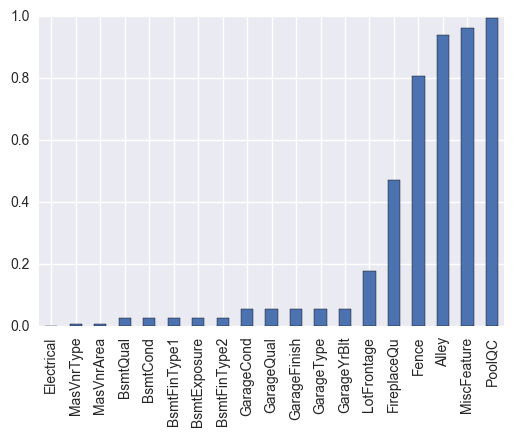

In [193]:
missing = df_train.isnull().sum()
missing = missing[missing>0]/df_train.shape[0]
missing.sort_values().plot.bar()

In [194]:
df_train.query('PoolArea > 0')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
197,198,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,...,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml,235000
810,811,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal,181000
1170,1171,80,RL,76.0,9880,Pave,NaN,Reg,Lvl,AllPub,...,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal,171000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1386,1387,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,...,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal,250000
1423,1424,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,...,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca,274970


In [195]:
df_train.query('Fireplaces > 0').shape

(770, 81)

### メモ
* PoolIQC はプールのクオリティ．殆どの家にプールなんかついてないからそりゃ欠損ばっかりか．そもそもPoolArea(プールの面積)が0より大きい物件が7件しかない．
* MiscFeature は他カテゴリに含まれない別の情報．エレベータとか2つ目のガレージとか．
* Alley は物件への路地の様子．砂利か舗装されているか路地が無いか．
* Fence はフェンスがあるかどうか．
* FirePlaceQu は暖炉のクオリティ．半分くらいの家にはそもそも暖炉がない．

## それぞれの特徴量について

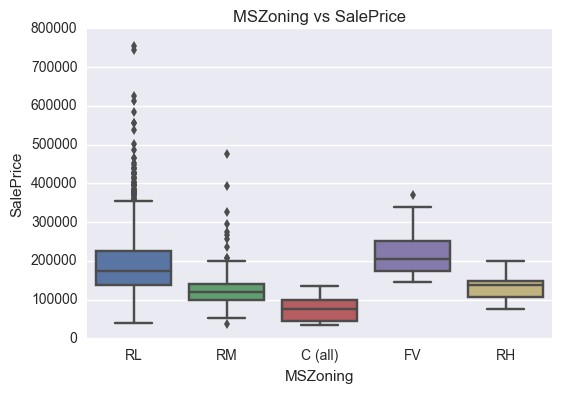

In [196]:
feature = 'MSZoning'
ax = sns.boxplot(df_train[feature], df_train['SalePrice'])
ax.set_title(feature + ' vs SalePrice')

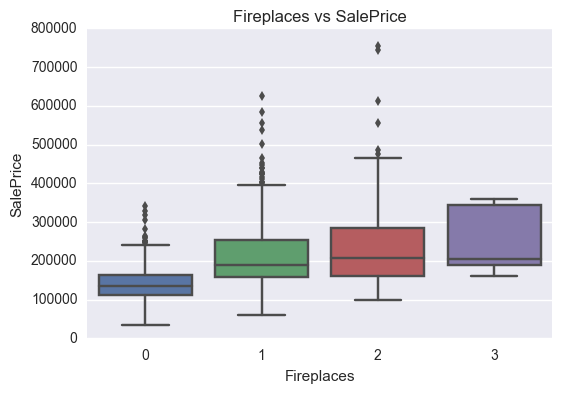

In [197]:
feature = 'Fireplaces'
ax = sns.boxplot(df_train[feature], df_train['SalePrice'])
ax.set_title(feature + ' vs SalePrice')

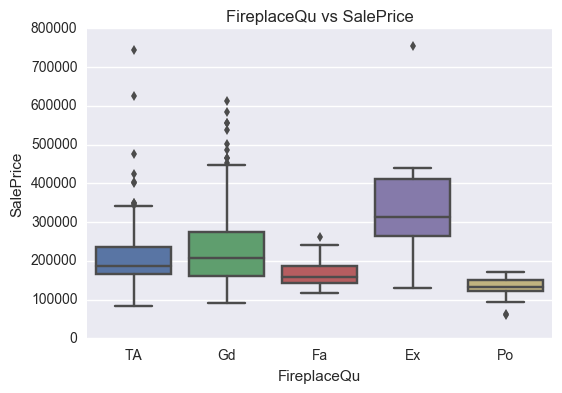

In [198]:
feature = 'FireplaceQu'
ax = sns.boxplot(df_train[feature], df_train['SalePrice'])
ax.set_title(feature + ' vs SalePrice')

## とりあえず簡単なベースラインを作ってみる

### quantative featureだけ

In [199]:
def RMSE(actual, pred):
    return np.sqrt(np.average(np.square(actual - pred)))

def log_RMSE(actual, pred):
    log_actual = np.log(np.maximum(1, actual))
    log_pred = np.log(np.maximum(1, pred))
    return np.sqrt(np.average(np.square(log_actual - log_pred)))

def fig_actual_vs_pred(actual, pred, val_range = [0, 100]):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(actual, pred)
    ax.set_xlim(val_range[0], val_range[1])
    ax.set_ylim(val_range[0], val_range[1])
    ax.set_xlabel('actual')
    ax.set_ylabel('pred')
    ax.plot(np.arange(val_range[0], val_range[1]),np.arange(val_range[0], val_range[1]) , color='m')
    return fig, ax


random forest
train RMSE: 14367.9750089
test RMSE: 37774.6950523
test log_RMSE: 0.155689091128

lasso
train RMSE: 33611.4981838
test RMSE: 39802.7812278
test log_RMSE: 0.168490317928

OLS
train RMSE: 33520.6305712
test RMSE: 39645.8236242
test log_RMSE: 0.171353483318

B_Ridge
train RMSE: 33614.0101031
test RMSE: 39372.4930118
test log_RMSE: 0.168418894494


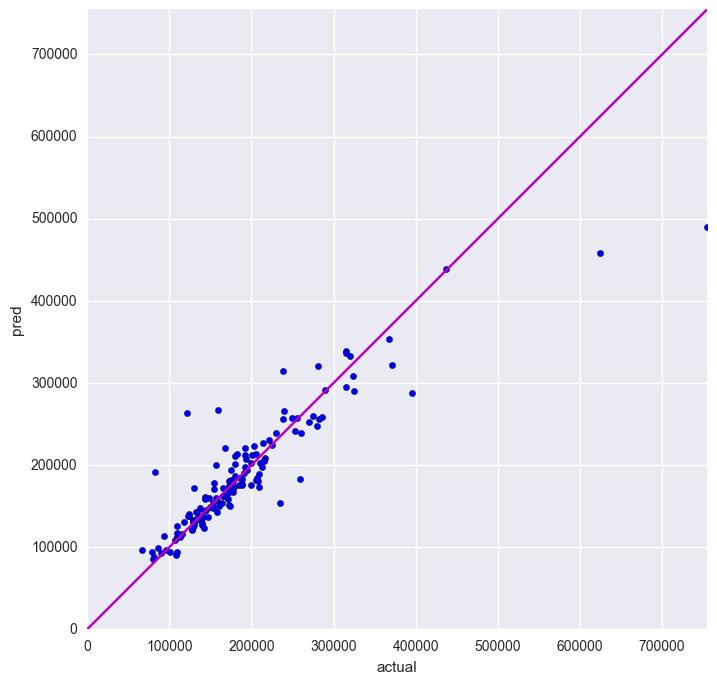

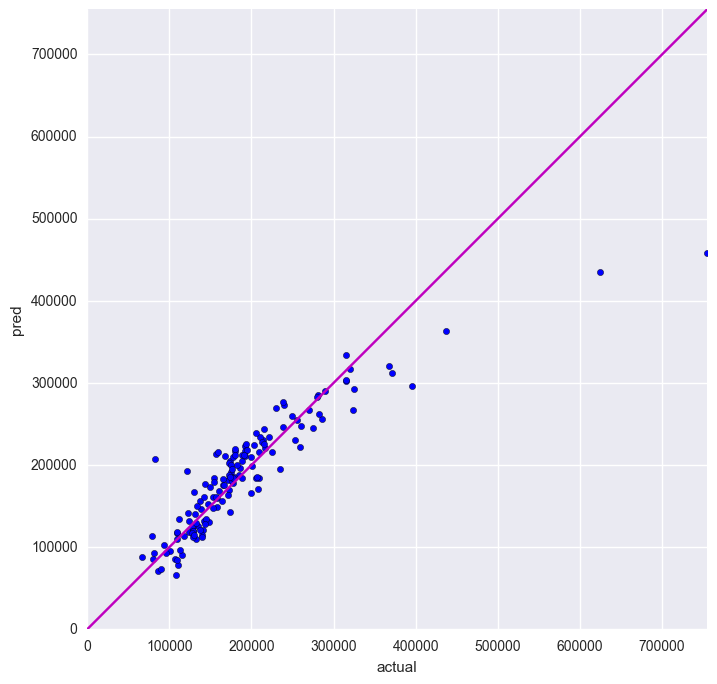

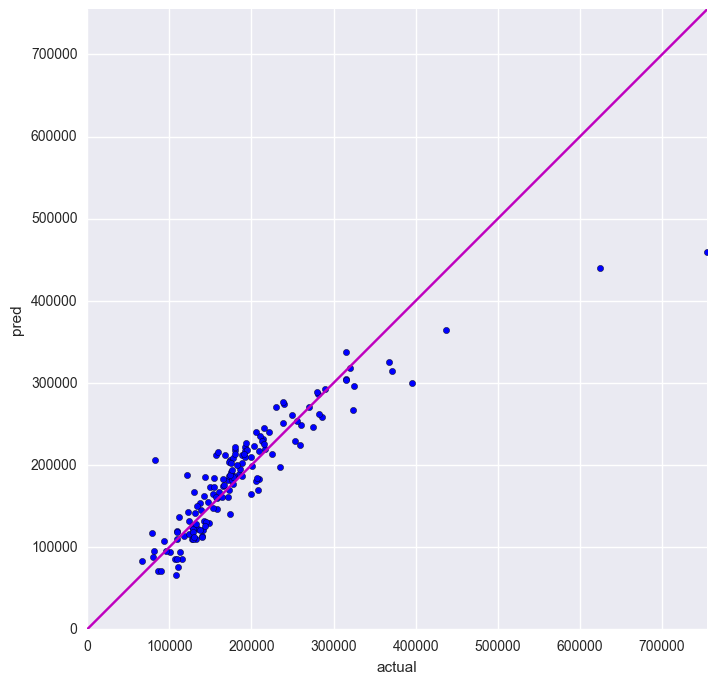

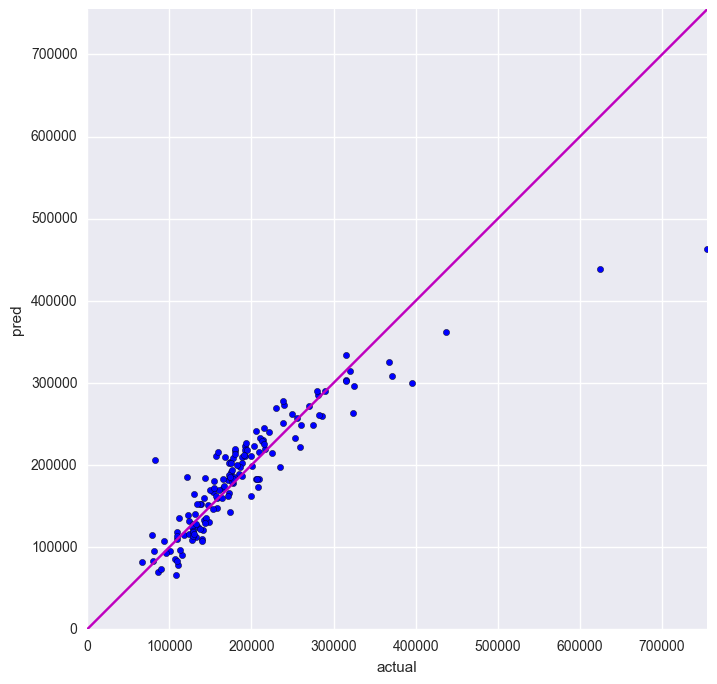

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn import ensemble

def apply_predictor(predictor, X_train, X_test, Y_train, Y_test):
    predictor.fit(X_train, Y_train)
    
    Y_pred_train = predictor.predict(X_train)
    Y_pred_test = predictor.predict(X_test)
    
    print "train RMSE: {}".format(np.sqrt(mean_squared_error(Y_train, Y_pred_train)))
    print "test RMSE: {}".format(np.sqrt(mean_squared_error(Y_test, Y_pred_test)))
    print "test log_RMSE: {}".format(np.sqrt(mean_squared_log_error(Y_test, Y_pred_test)))
    fig = fig_actual_vs_pred(Y_test, Y_pred_test, [0, np.max(Y)])

X = df_train[quantitative].fillna(0.)
Y = df_train['SalePrice']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

# random forest
print "\nrandom forest"
random_forest = ensemble.RandomForestRegressor()
apply_predictor(random_forest, X_train, X_test, Y_train, Y_test)

# lasso
print "\nlasso"
lasso = linear_model.LassoLarsCV(max_iter=10000)
apply_predictor(lasso, X_train, X_test, Y_train, Y_test)

# OLS
print "\nOLS"
OLS = linear_model.LinearRegression()
apply_predictor(OLS, X_train, X_test, Y_train, Y_test)

# Bayesian Ridge
print "\nB_Ridge"
B_Ridge = linear_model.BayesianRidge()
apply_predictor(B_Ridge, X_train, X_test, Y_train, Y_test)

### qualitative もやりますよ

In [205]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
df_train_encoded = df_train.copy()
for q in qualitative:  
    encode(df_train_encoded, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


### qualitative だけ


random forest
train RMSE: 16311.7434307
test RMSE: 33869.445081
test log_RMSE: 0.189379895779

lasso
train RMSE: 42364.4267313
test RMSE: 39432.512768
test log_RMSE: 0.220152253476

OLS
train RMSE: 42001.5909063
test RMSE: 40600.9971897
test log_RMSE: 0.227088602509

B_Ridge
train RMSE: 42274.2531826
test RMSE: 39368.0697865
test log_RMSE: 0.225366772454


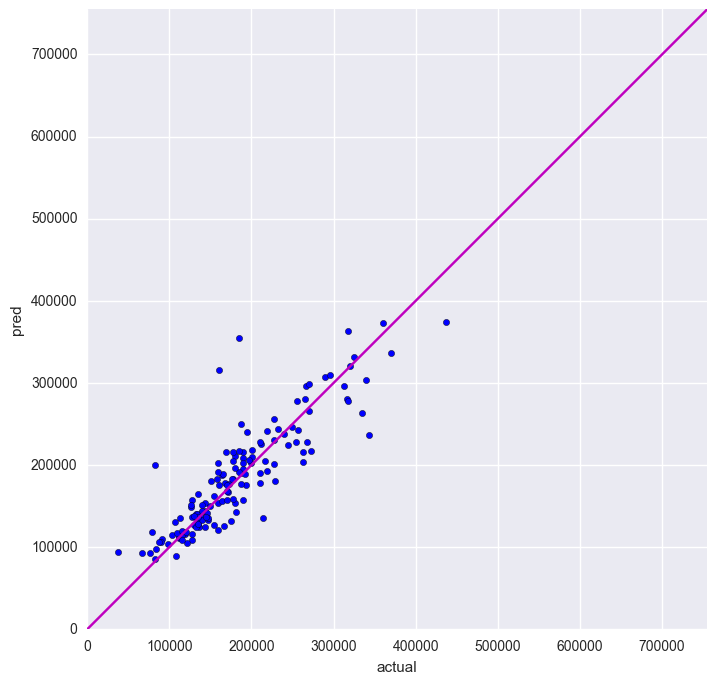

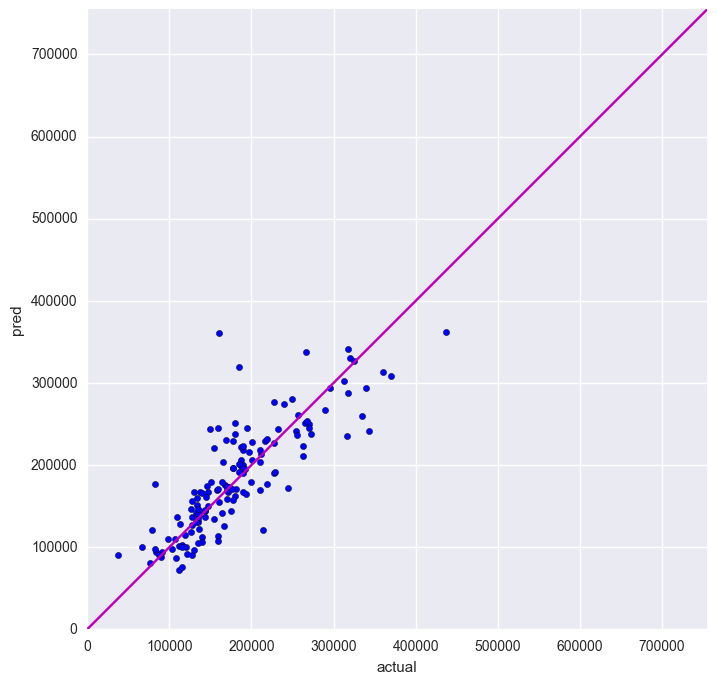

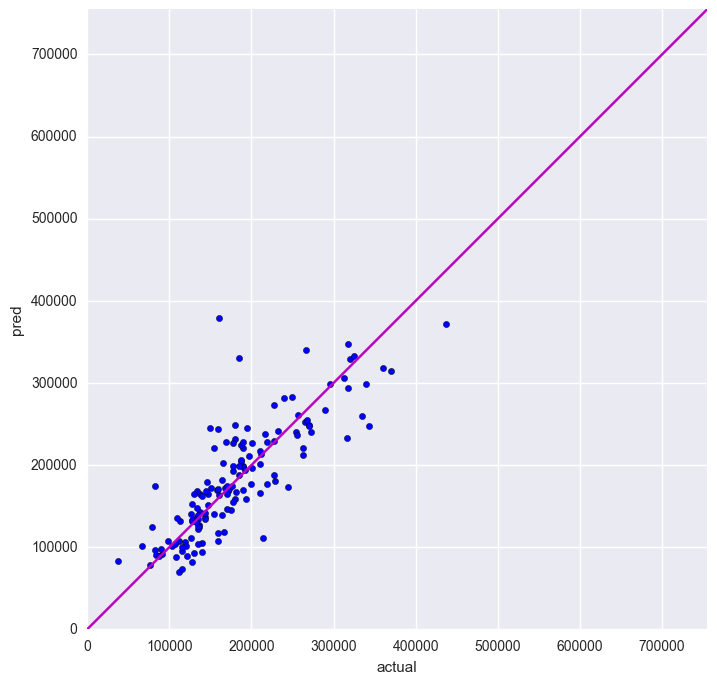

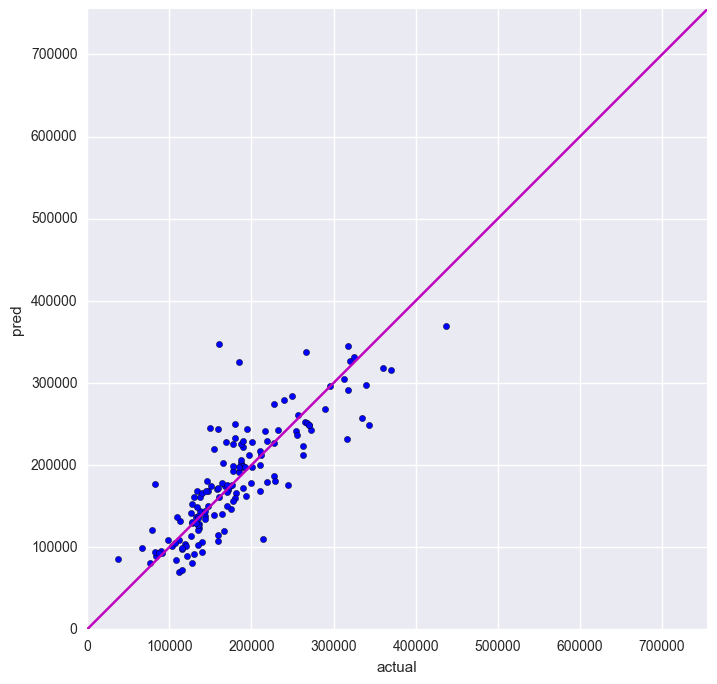

In [211]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn import ensemble

def apply_predictor(predictor, X_train, X_test, Y_train, Y_test):
    predictor.fit(X_train, Y_train)
    
    Y_pred_train = predictor.predict(X_train)
    Y_pred_test = predictor.predict(X_test)
    
    print "train RMSE: {}".format(np.sqrt(mean_squared_error(Y_train, Y_pred_train)))
    print "test RMSE: {}".format(np.sqrt(mean_squared_error(Y_test, Y_pred_test)))
    print "test log_RMSE: {}".format(np.sqrt(mean_squared_log_error(Y_test, Y_pred_test)))
    fig = fig_actual_vs_pred(Y_test, Y_pred_test, [0, np.max(Y)])

X = df_train_encoded[qual_encoded].fillna(0.)
Y = df_train_encoded['SalePrice']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

# random forest
print "\nrandom forest"
random_forest = ensemble.RandomForestRegressor()
apply_predictor(random_forest, X_train, X_test, Y_train, Y_test)

# lasso
print "\nlasso"
lasso = linear_model.LassoLarsCV(max_iter=10000)
apply_predictor(lasso, X_train, X_test, Y_train, Y_test)

# OLS
print "\nOLS"
OLS = linear_model.LinearRegression()
apply_predictor(OLS, X_train, X_test, Y_train, Y_test)

# Bayesian Ridge
print "\nB_Ridge"
B_Ridge = linear_model.BayesianRidge()
apply_predictor(B_Ridge, X_train, X_test, Y_train, Y_test)


random forest
train RMSE: 12805.645706
test RMSE: 21752.4299146
test log_RMSE: 0.121289992213

lasso
train RMSE: 33668.4441949
test RMSE: 27332.9470101
test log_RMSE: 0.148102563516

OLS
train RMSE: 30173.2403917
test RMSE: 27850.6519809
test log_RMSE: 0.188892935288

B_Ridge
train RMSE: 31238.9653604
test RMSE: 24842.7300032
test log_RMSE: 0.1401080851


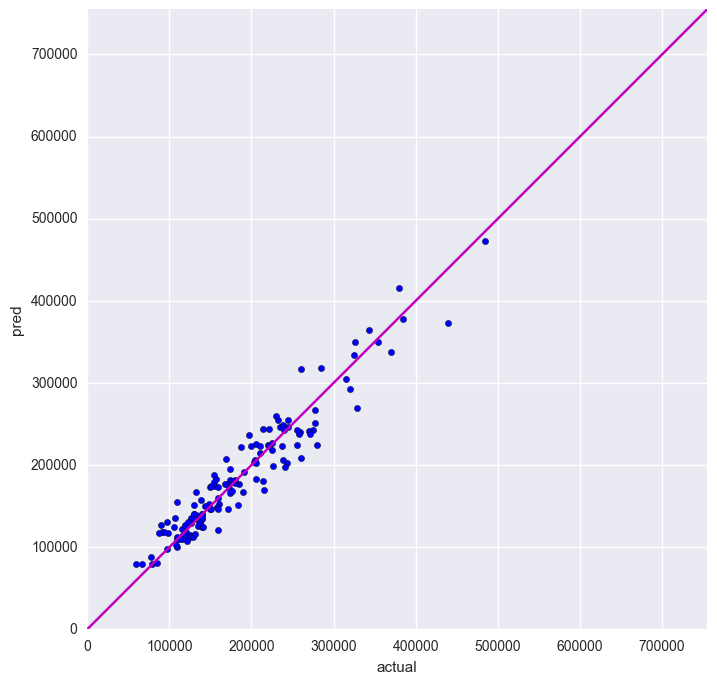

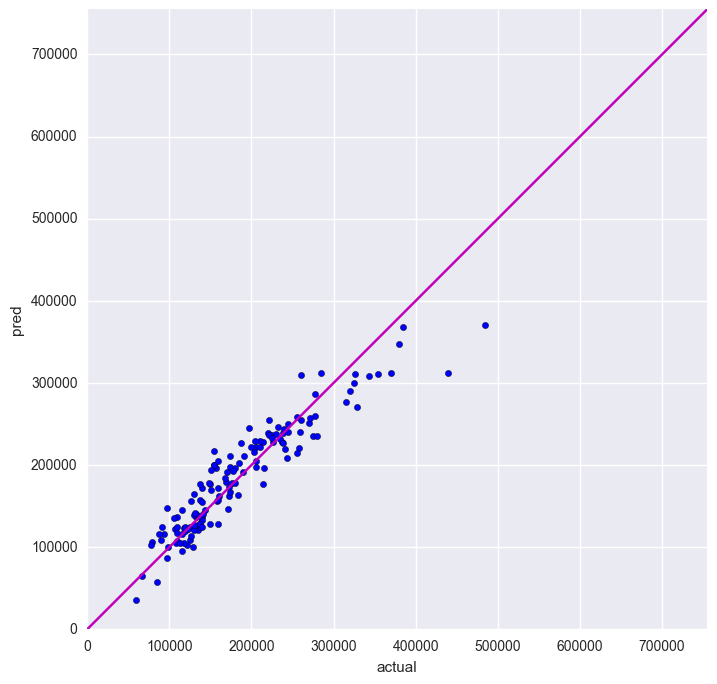

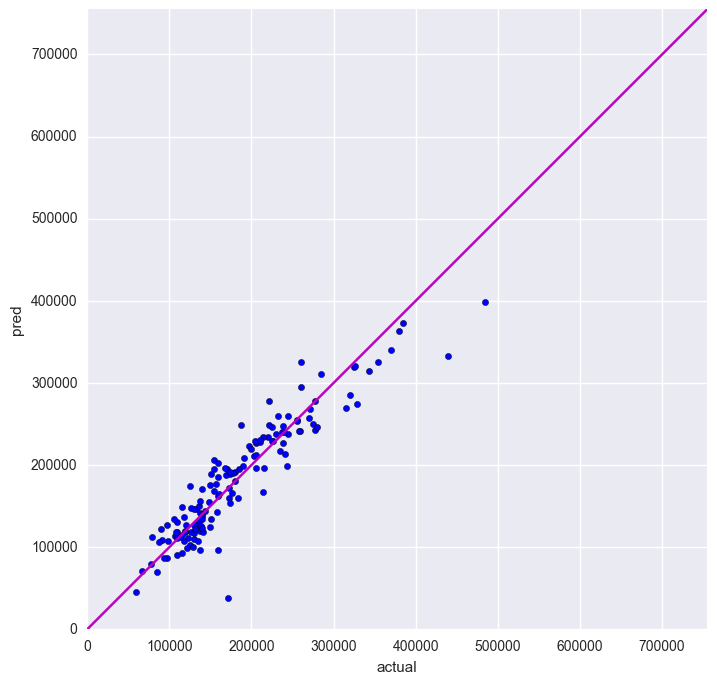

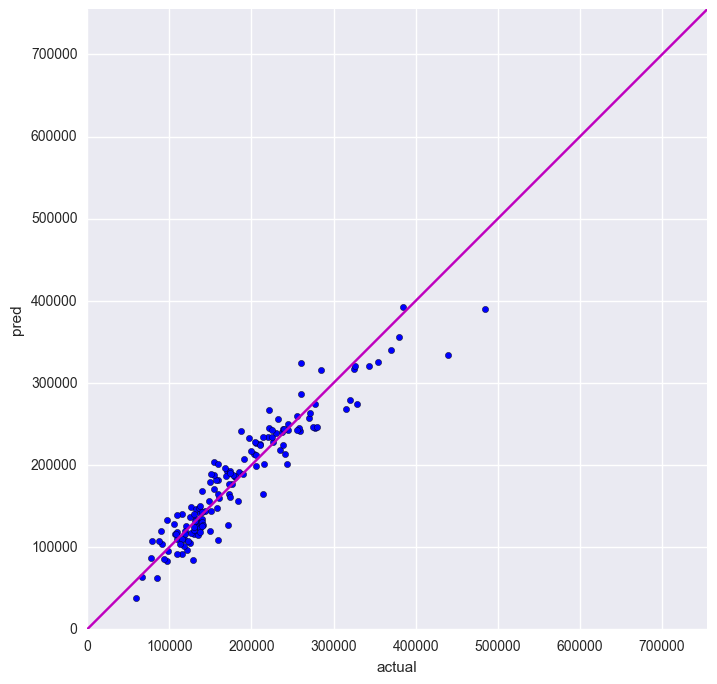

In [204]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn import ensemble

def apply_predictor(predictor, X_train, X_test, Y_train, Y_test):
    predictor.fit(X_train, Y_train)
    
    Y_pred_train = predictor.predict(X_train)
    Y_pred_test = predictor.predict(X_test)
    
    print "train RMSE: {}".format(np.sqrt(mean_squared_error(Y_train, Y_pred_train)))
    print "test RMSE: {}".format(np.sqrt(mean_squared_error(Y_test, Y_pred_test)))
    print "test log_RMSE: {}".format(np.sqrt(mean_squared_log_error(Y_test, Y_pred_test)))
    fig = fig_actual_vs_pred(Y_test, Y_pred_test, [0, np.max(Y)])

X = df_train_encoded[quantitative + qual_encoded].fillna(0.)
Y = df_train_encoded['SalePrice']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

# random forest
print "\nrandom forest"
random_forest = ensemble.RandomForestRegressor()
apply_predictor(random_forest, X_train, X_test, Y_train, Y_test)

# lasso
print "\nlasso"
lasso = linear_model.LassoLarsCV(max_iter=10000)
apply_predictor(lasso, X_train, X_test, Y_train, Y_test)

# OLS
print "\nOLS"
OLS = linear_model.LinearRegression()
apply_predictor(OLS, X_train, X_test, Y_train, Y_test)

# Bayesian Ridge
print "\nB_Ridge"
B_Ridge = linear_model.BayesianRidge()
apply_predictor(B_Ridge, X_train, X_test, Y_train, Y_test)

## 特徴量職人する

In [ ]:
qualitative